<a href="https://colab.research.google.com/github/AFIGA97/Customer_Churn_Analysis/blob/main/Trader_Behavior_Insights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Trader Behavior Insights – Bitcoin Sentiment vs Performance**

# **Introduction**
This project analyzes how crypto traders’ performance changes across different Bitcoin market sentiment regimes using Hyperliquid historical trade data combined with the Bitcoin Fear & Greed Index. It links each trade to the prevailing sentiment (e.g., Fear, Greed, Extreme Fear, Extreme Greed) and studies how metrics like PnL and position size vary across those regimes. The goal is to uncover behavior patterns and risk tendencies that can inform more robust and sentiment‑aware trading strategies.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


## **Load the two files**

In [ ]:
traders = pd.read_csv("historical_data.csv")
sentiment = pd.read_csv("fear_greed_index.csv")

traders.head()


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [ ]:
sentiment.head()


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


**Check traders columns and convert times**

In [ ]:
traders.head()
traders.info()
sentiment.head()
sentiment.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102574 entries, 0 to 102573
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           102574 non-null  object 
 1   Coin              102574 non-null  object 
 2   Execution Price   102574 non-null  float64
 3   Size Tokens       102574 non-null  float64
 4   Size USD          102574 non-null  float64
 5   Side              102574 non-null  object 
 6   Timestamp IST     102574 non-null  object 
 7   Start Position    102574 non-null  float64
 8   Direction         102574 non-null  object 
 9   Closed PnL        102574 non-null  float64
 10  Transaction Hash  102574 non-null  object 
 11  Order ID          102574 non-null  int64  
 12  Crossed           102574 non-null  bool   
 13  Fee               102574 non-null  float64
 14  Trade ID          102574 non-null  float64
 15  Timestamp         102573 non-null  float64
dtypes: bool(1), float64(

In [ ]:
traders['time'] = pd.to_datetime(traders['Timestamp IST'], format='%d-%m-%Y %H:%M')
sentiment['Date'] = pd.to_datetime(sentiment['date'], format='%Y-%m-%d')

traders['date'] = traders['time'].dt.date
sentiment['date'] = sentiment['Date'].dt.date

**Merge trades with sentiment**

In [ ]:
merged = pd.merge(
    traders,
    sentiment[['date', 'classification']],
    on='date',
    how='left'
)

merged.rename(columns={'classification': 'sentiment'}, inplace=True)
merged[['time', 'date', 'sentiment']].head()


,time,date,sentiment
0,2024-12-02 22:50:00,2024-12-02,Extreme Greed
1,2024-12-02 22:50:00,2024-12-02,Extreme Greed
2,2024-12-02 22:50:00,2024-12-02,Extreme Greed
3,2024-12-02 22:50:00,2024-12-02,Extreme Greed
4,2024-12-02 22:50:00,2024-12-02,Extreme Greed


**Make sure key columns are numeric**

In [ ]:
merged['Closed PnL'] = pd.to_numeric(merged['Closed PnL'], errors='coerce')
merged['Size USD']   = pd.to_numeric(merged['Size USD'], errors='coerce')
merged['Size Tokens'] = pd.to_numeric(merged['Size Tokens'], errors='coerce')
merged['Fee']        = pd.to_numeric(merged['Fee'], errors='coerce')

merged[['Closed PnL', 'Size USD', 'Size Tokens', 'Fee']].describe()


,Closed PnL,Size USD,Size Tokens,Fee
count,102574.000000,1.025740e+05,1.025740e+05,102574.000000
mean,74.155629,8.039369e+03,6.720277e+03,1.593514
std,1160.468793,4.938023e+04,1.455820e+05,8.669726
min,-117990.104100,0.000000e+00,5.330000e-06,-1.175712
25%,0.000000,2.084800e+02,8.700000e-01,0.009823
50%,0.000000,7.896600e+02,2.003120e+01,0.082293
75%,8.065889,2.997310e+03,1.273150e+02,0.506370
max,135329.090100,3.921431e+06,1.582244e+07,837.471593


**Overall performance by sentiment**

In [ ]:
sent_perf = (
    merged
    .groupby('sentiment')
    .agg(
        avg_pnl   = ('Closed PnL', 'mean'),
        median_pnl= ('Closed PnL', 'median'),
        trades    = ('Closed PnL', 'count'),
        avg_size  = ('Size USD', 'mean')
    )
    .reset_index()
)

sent_perf


,sentiment,avg_pnl,median_pnl,trades,avg_size
0,Extreme Fear,74.125083,0.000000,7705,5103.345014
1,Extreme Greed,113.628673,0.029436,15355,5589.016434
2,Fear,76.115721,0.000000,32981,10119.305529
3,Greed,62.838622,0.000000,25187,9196.258720
4,Neutral,54.122609,0.000000,21340,6280.692866


**Simple visualizations**

**1.Barplot of average PnL by sentiment**


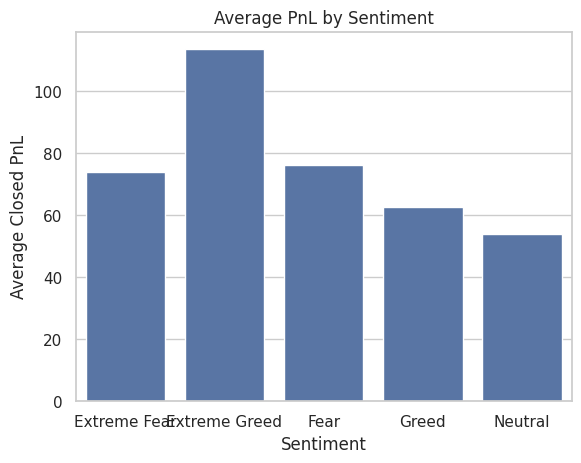

In [ ]:
sns.barplot(data=sent_perf, x='sentiment', y='avg_pnl')
plt.title("Average PnL by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Average Closed PnL")
plt.show()


**2.Boxplot of trade size by sentiment**

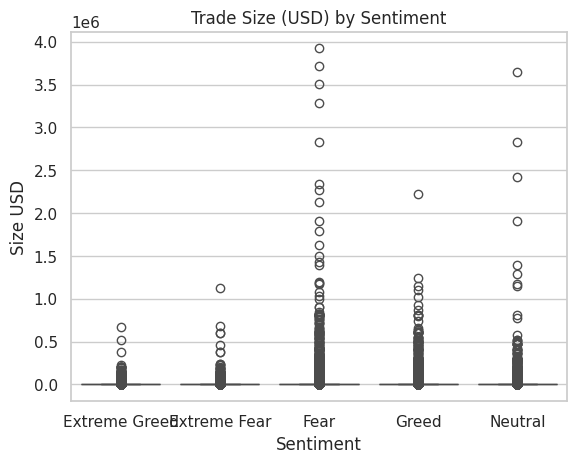

In [ ]:
sns.boxplot(data=merged, x='sentiment', y='Size USD')
plt.title("Trade Size (USD) by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Size USD")
plt.show()


**Average PnL by sentiment (table + barplot)**

In [ ]:
sent_perf = (
    merged
    .groupby('sentiment')
    .agg(
        avg_pnl    = ('Closed PnL', 'mean'),
        median_pnl = ('Closed PnL', 'median'),
        trades     = ('Closed PnL', 'count')
    )
    .reset_index()
)

sent_perf


,sentiment,avg_pnl,median_pnl,trades
0,Extreme Fear,74.125083,0.000000,7705
1,Extreme Greed,113.628673,0.029436,15355
2,Fear,76.115721,0.000000,32981
3,Greed,62.838622,0.000000,25187
4,Neutral,54.122609,0.000000,21340


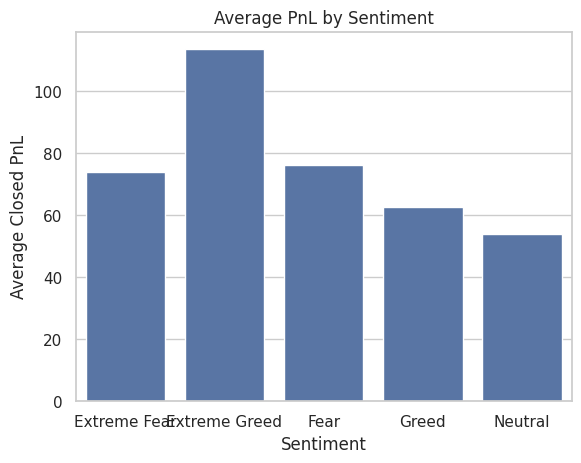

In [ ]:
sns.barplot(data=sent_perf, x='sentiment', y='avg_pnl')
plt.title("Average PnL by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Average Closed PnL")
plt.show()


**Performance by trader and sentiment**

In [ ]:
acct_sent = (
    merged
    .groupby(['Account', 'sentiment'])
    .agg(
        total_pnl = ('Closed PnL', 'sum'),
        avg_pnl   = ('Closed PnL', 'mean'),
        trades    = ('Closed PnL', 'count')
    )
    .reset_index()
)

acct_sent.head()


,Account,sentiment,total_pnl,avg_pnl,trades
0,0x083384f897ee0f19899168e3b1bec365f52a9012,Extreme Fear,1.247692e+05,1247.692214,100
1,0x083384f897ee0f19899168e3b1bec365f52a9012,Extreme Greed,-4.028234e+04,-42.626810,945
2,0x083384f897ee0f19899168e3b1bec365f52a9012,Fear,1.113374e+06,626.194346,1778
3,0x083384f897ee0f19899168e3b1bec365f52a9012,Greed,2.767193e+05,482.089321,574
4,0x083384f897ee0f19899168e3b1bec365f52a9012,Neutral,1.256501e+05,298.456334,421


# **Insights so far**
**Overall performance vs sentiment:** Average Closed PnL per trade is positive across all sentiment regimes and is highest during Extreme Greed and Fear periods, while Neutral and Greed regimes show lower average PnL.
​

**Trade size vs sentiment:** Average USD trade size is largest during Fear and Greed, indicating traders tend to deploy more capital when sentiment is strongly directional (either optimistic or pessimistic) than when it is Neutral.
​

**Trader‑level differences:** Some accounts earn high average PnL in Fear and Greed regimes but perform worse in Extreme Greed, suggesting that very euphoric markets may encourage over‑risking for certain traders.
​

**Skewed PnL distribution:** Median Closed PnL is near zero in most regimes, while mean PnL is positive, implying a few large profitable trades drive a significant portion of overall returns.
​

# **Conclusion & strategy ideas**

- Trader performance remains positive across all sentiment regimes, but profitability peaks when sentiment is at extremes (Extreme Fear / Extreme Greed), suggesting that volatility in those regimes creates more opportunity.  
- Because median PnL is near zero while mean PnL is positive, risk appears concentrated in a small number of very large trades; sizing and risk management on outlier trades is critical.  
- Since traders tend to scale up position sizes in Fear and Greed regimes, a more robust strategy would include stricter position limits and stop-loss rules during these periods to avoid over-exposure.  
- Account-level differences across regimes indicate that some traders are “regime specialists”; a potential improvement is to adapt exposure based on which sentiment regime each trader historically performs best in.
